# Optimal thermal control with distributed QP

The objective of this study is to determine a model of energy distribution which requires a quadratic programming in order to optimize the supply. We will compare two different methods : centralized and distributed optimization.

--Sylvain Chatel, June 2016--

We have developped the StaticOptimization package in order to solve this matter.

In [1]:
from __future__ import division, print_function
import StaticOptimization as SO
from cvxopt import matrix, solvers
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
%matplotlib inline

/Users/sylvainchatel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Problem definition

We consider  n differents users (rooms). Each room has an ideal temperature which maximises its comfort. Howerever, the amount of energy available is limited and so is the amount each room can receive.

Hence, we must proceed to an optimization in order to distribute the energy available to all users maximising the global confort.

Let them be $n$ rooms, with each a miximum amount of energy $ U_m $. The total amount of energy is $ U_{max} $. Each room deisres an ideal temperature $ T_{id} $ in comparison to the external temperature $ T_{ext} $.

<img src='therm_diagram.png' width='500'>

The objective function is as follow :
$$ J(u) = J_{energy}(u) + \alpha J_{comfort}(u) $$

$\alpha$ represents the importance of the comfort. The comfort function is modelled by a mean squarred error to the ideal temperature.

So the objective function is :

$$ J(u) = <\textbf{1}, u> + \alpha \sum_{i=1}^{n} Rth^{i}(u_i-u_i^{ideal}) $$

Where $Rth_i$ stands for the thermal resistance of the room $i$. 


The optimization problem is given by the following constraints :
$$ \sum_{n=1}^{n} u_i < U_{max} $$

$$ \forall\; i\; \in [0, n], \; 0 \leq u_{i} \leq u_{imax} $$

*Note : In order to keep the optimization problem interesting, the total amount of energy should be inferior to the sum of the ideal energies of each room.* 

## QP problem

### Variables definitions

Here can be defined all variables :

In [2]:
n = 4
i = np.arange(n)
# max energy in kW
Umax = 10
u_m = np.array([3, 3, 3, 3], dtype=float)
assert len(u_m) == n
# thermal resistance
beta = 5
Rth = beta / u_m
# Exterior temperature
Text = 15
# Ideal temperature in degrees
T_id = np.array([20, 21, 22, 25], dtype=float)
assert len(T_id) == n
# comfort factor
alpha = np.array([10, 10, 10, 10], dtype=float)

pb = dict(Rth=Rth, Text=Text, T_id=T_id, Umax=Umax, u_m=u_m, alpha=alpha)
pb

{'Rth': array([ 1.66666667,  1.66666667,  1.66666667,  1.66666667]),
 'T_id': array([ 20.,  21.,  22.,  25.]),
 'Text': 15,
 'Umax': 10,
 'alpha': array([ 10.,  10.,  10.,  10.]),
 'u_m': array([ 3.,  3.,  3.,  3.])}

Then we resolve the QP :

In [3]:
u_sol_c = SO.optim_central(pb)
u_sol_d = SO.optim_decen(pb, 15, 1.0e-2)
print(u_sol_d[2])

(4,)
(4,)
break at 6.
6


*Note :The break count enable the reader to check the number of iteration realized in the Uzawa method.*

### Results :

**First the centralized solution**

In [4]:
reload(SO)

<module 'StaticOptimization' from 'StaticOptimization.pyc'>

---------  ---------  ---------  ---------
-2.111098  -2.111098  -2.111136  -5.000002
 3.000000   3.000000   3.000000   3.000000
 3.000000   3.600000   4.200000   6.000000
 1.733341   2.333341   2.933318   2.999999
---------  ---------  ---------  ---------
9.99999995076


(<matplotlib.figure.Figure at 0x104685dd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10cd32c50>)

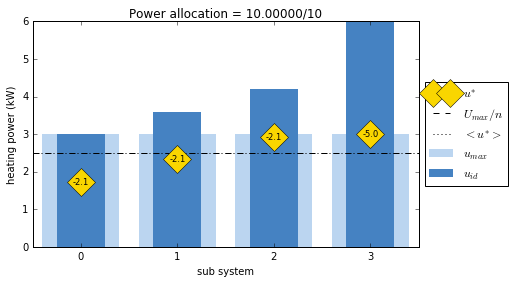

In [5]:
SO.print_sol(pb, u_sol_c)
SO.plot_sol(pb, u_sol_c, False)

**Then the distributed solution**

---------  ---------  ---------  ---------
-2.108574  -2.108574  -2.108581  -5.000000
 3.000000   3.000000   3.000000   3.000000
 3.000000   3.600000   4.200000   6.000000
 1.734856   2.334855   2.934851   3.000000
---------  ---------  ---------  ---------
10.0045621977


(<matplotlib.figure.Figure at 0x10fa55bd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fa39190>)

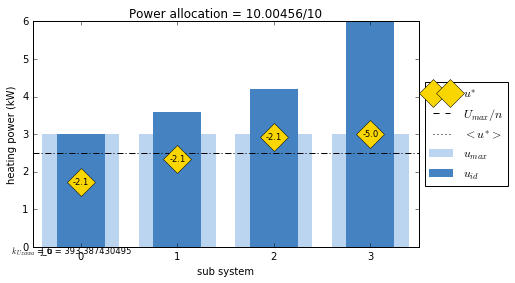

In [6]:
SO.print_sol(pb, u_sol_d)
SO.plot_sol(pb, u_sol_d)

Observation : 
   *  In both cases, we reach the optimal enregy distribution to maximize the comfort in regards to the  ressources.
   *  The distributed method is based on a recursive protocol. We must keep in mind that a step to high might force the serie to diverge.
   *  we can verify the week duality : $ J(u_{cent}^{*}) < J(u_{dist}^{*} ) $.

### Parametric analysis

In this section, we analyse the influence of the different parameters on the optimal solution. We especially want to determine the results given by the distributed approch.

#### Influence of the problem's entries

In [7]:
Umax = 30
Text = 15
alpha = np.array([10, 10, 10, 10, 10, 10])

u_m1 = np.array([5, 5, 5, 5, 5, 5], dtype=float)
T_id1 = np.array([21, 23, 25, 25, 25, 21], dtype=float)
Rth1 = beta / u_m1

u_m2 = np.array([5, 5, 5, 8, 10, 10], dtype=float)
T_id2 = np.array([21, 23, 25, 25, 25, 21], dtype=float)
Rth2 = beta / u_m2

pb1 = dict(Rth=Rth1, Text=Text, T_id=T_id1, Umax=Umax, u_m=u_m1, alpha=alpha)
pb2 = dict(Rth=Rth2, Text=Text, T_id=T_id2, Umax=Umax, u_m=u_m2, alpha=alpha)

(6,)
(6,)
(6,)
(6,)


(<matplotlib.figure.Figure at 0x10469f790>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10cf590d0>)

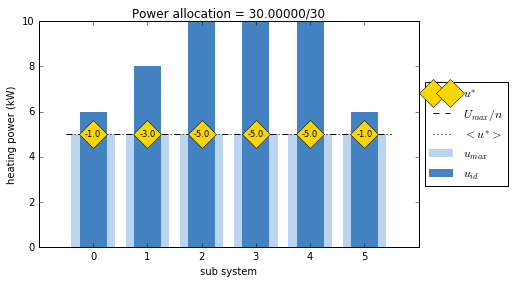

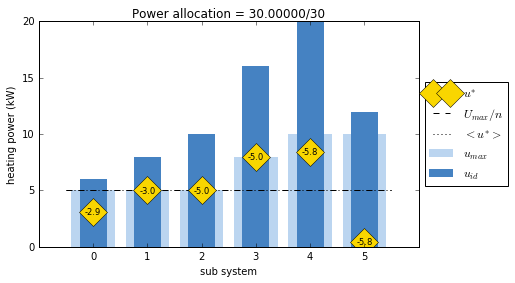

In [8]:
SO.plot_sol(pb1, SO.optim_central(pb1), False)
SO.plot_sol(pb2, SO.optim_central(pb2), False)

*Note : We can see on both graph above that in the ideal case where $\sum_{n=1}^{n} u_{max} = U_{max}$*, all the available ressources are used. If the ressources are not enough they are distributed so that all users are satisfied as a whole.

break at 0.
break at 1.


(<matplotlib.figure.Figure at 0x11073e7d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110d627d0>)

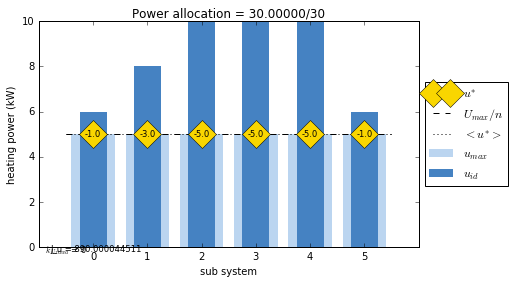

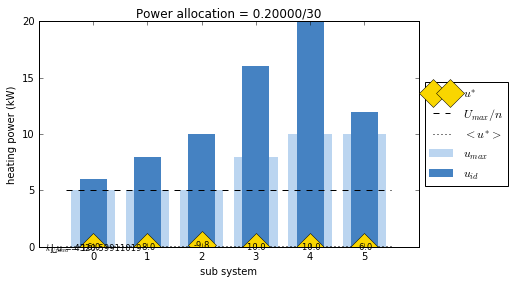

In [9]:
SO.plot_sol(pb1, SO.optim_decen(pb1, 15, 1.0e-2))
SO.plot_sol(pb2, SO.optim_decen(pb2, 15, 1.0e-2))

### Influence of the program parameters

In this section, we want to determine the influence of parameters such as the step, the error precision and the number of iteration max on the distributed solution.

*  Centralized case :

(6,)
(6,)


(<matplotlib.figure.Figure at 0x10cf592d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10fd0e050>)

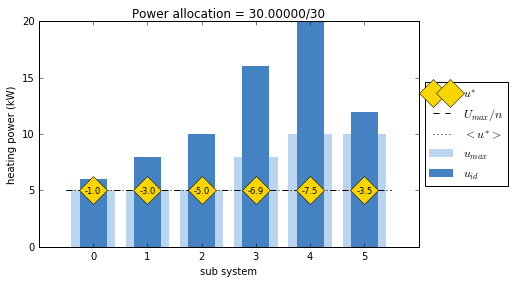

In [10]:
SO.plot_sol(pb2, SO.optim_central(pb1), False)

*  Distributed case 1 :

break at 1.


(<matplotlib.figure.Figure at 0x110f65750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110f9c410>)

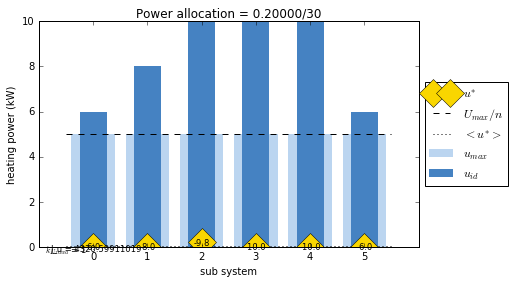

In [11]:
SO.plot_sol(pb1, SO.optim_decen(pb2, 15, 1.0e-4))

*  Distributed case 2 :

break at 1.


(<matplotlib.figure.Figure at 0x110320f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x110d11c10>)

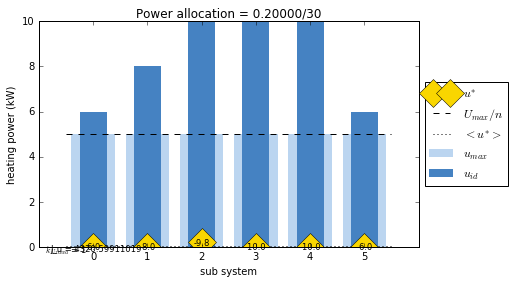

In [12]:
SO.plot_sol(pb1, SO.optim_decen(pb2, 15, 1.0e-6))

*  Centralized case :

In [13]:
SO.print_sol(pb2, SO.optim_central(pb1))

(6,)
(6,)
---------  ---------  ---------  ---------  ---------  ---------
-1.000001  -3.000000  -5.000000  -6.875000  -7.500000  -3.500000
 5.000000   5.000000   5.000000   8.000000  10.000000  10.000000
 6.000000   8.000000  10.000000  16.000000  20.000000  12.000000
 4.999999   5.000000   5.000000   5.000000   5.000000   4.999999
---------  ---------  ---------  ---------  ---------  ---------
29.9999980459


*  Distributed case 1 :

In [14]:
SO.print_sol(pb2, SO.optim_decen(pb1, 15, 1.0e-6))

break at 0.
---------  ---------  ---------  ---------  ---------  ---------
-1.000001  -3.000000  -5.000000  -6.875000  -7.500000  -3.500000
 5.000000   5.000000   5.000000   8.000000  10.000000  10.000000
 6.000000   8.000000  10.000000  16.000000  20.000000  12.000000
 4.999999   5.000000   5.000000   5.000000   5.000000   4.999999
---------  ---------  ---------  ---------  ---------  ---------
29.9999985522


*  Distributed case 2 :

In [15]:
SO.print_sol(pb2, SO.optim_decen(pb1, 15, 1.0e-6))

break at 0.
---------  ---------  ---------  ---------  ---------  ---------
-1.000001  -3.000000  -5.000000  -6.875000  -7.500000  -3.500000
 5.000000   5.000000   5.000000   8.000000  10.000000  10.000000
 6.000000   8.000000  10.000000  16.000000  20.000000  12.000000
 4.999999   5.000000   5.000000   5.000000   5.000000   4.999999
---------  ---------  ---------  ---------  ---------  ---------
29.9999985522


### Influence of the step in the Uzawa iteration

In [16]:
outfile = TemporaryFile()

In [17]:
reload(SO)

<module 'StaticOptimization' from 'StaticOptimization.pyc'>

In [18]:
def save_step(pb, step_min, step_max, nbr , e):
    step = np.logspace(np.log10(step_min), np.log10(step_max), nbr)
    
    U = []
    k_val = []
    L_val = []

    for x in np.nditer(step):
        u_sol, L, k, J_u= SO.optim_decen(pb, x, e, False)
        U.append(u_sol.sum()-pb['Umax'])
        L_val.append(L)
        k_val.append(k)

    np.savez(outfile, U=U, k_val=k_val, L_val=L_val, step_min=step_min, step_max=step_max, nbr=nbr, e=e)
    outfile.seek(0)

In [19]:
save_step(pb, 1, 250, 100, 1.0e-3)

In [20]:
def plot_step(outfile):
    """
        StaticOptimization.plot_sol(param, range, precision, error )
        Parameters : dictionary of parameters (Rth, Text, T_id, Umax, u_m, alpha), range of 
        step, 
        precision, error
        Returns : out graph of the distributed optimization total power allocation and the 
        centralized optimization
        total power allocation, the graph of the evolution of the Lagrangian multiplier and 
        the number of iteration
        regarding the step.
    """

    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    fig.tight_layout()
    
    sav = np.load(outfile)
    U = sav['U']
    k_val = sav['k_val']
    L_val = sav['L_val']
    step_min=sav['step_min']
    step_max=sav['step_max']
    nbr=sav['nbr']
    
    step = np.logspace(np.log10(step_min), np.log10(step_max), nbr)
    ax1.plot(step, U, '-+', label='$ PA^{*}$ distributed')
    ax2.plot(step, L_val, '-+')
    ax3.plot(step, k_val)
    ax1.set(
        ylabel='$ u^{*} $',
        title = 'mean to Umax as a function of the step of the Uzawa iteration'
    )
    ax2.set(
        ylabel='$ L $',
        title='Lagrangian multiplier as a function of the step of the Uzawa iteration'
    )
    ax3.set(
        ylabel='number of iteration',
        title='number of iteration as a function of the step of the Uzawa iteration'
    )

    plt.show()
    fig.savefig('step_opt.png', dpi=200, bbox_inches='tight')
    fig.savefig('step_opt.pdf', bbox_inches='tight')
    return fig, (ax1, ax2, ax3)

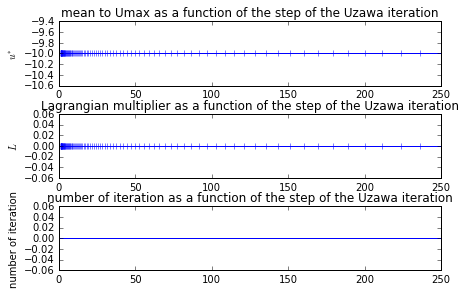

(<matplotlib.figure.Figure at 0x11050cb50>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x11056ec90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x111c372d0>))

In [21]:
plot_step(outfile)

# Conclusion

Throughout thsi study, we were able to understance how the Uzawa method works prior using it for the distributed MPC. Moreover, we pointed out the influence of the different parameters of the system. 